In [ ]:
! pip install "openai>=1" "langchain>=0.0.331rc2" matplotlib pillow

## Load Images

We encode to base64, as noted in the [OpenAI GPT-4V doc](https://platform.openai.com/docs/guides/vision).


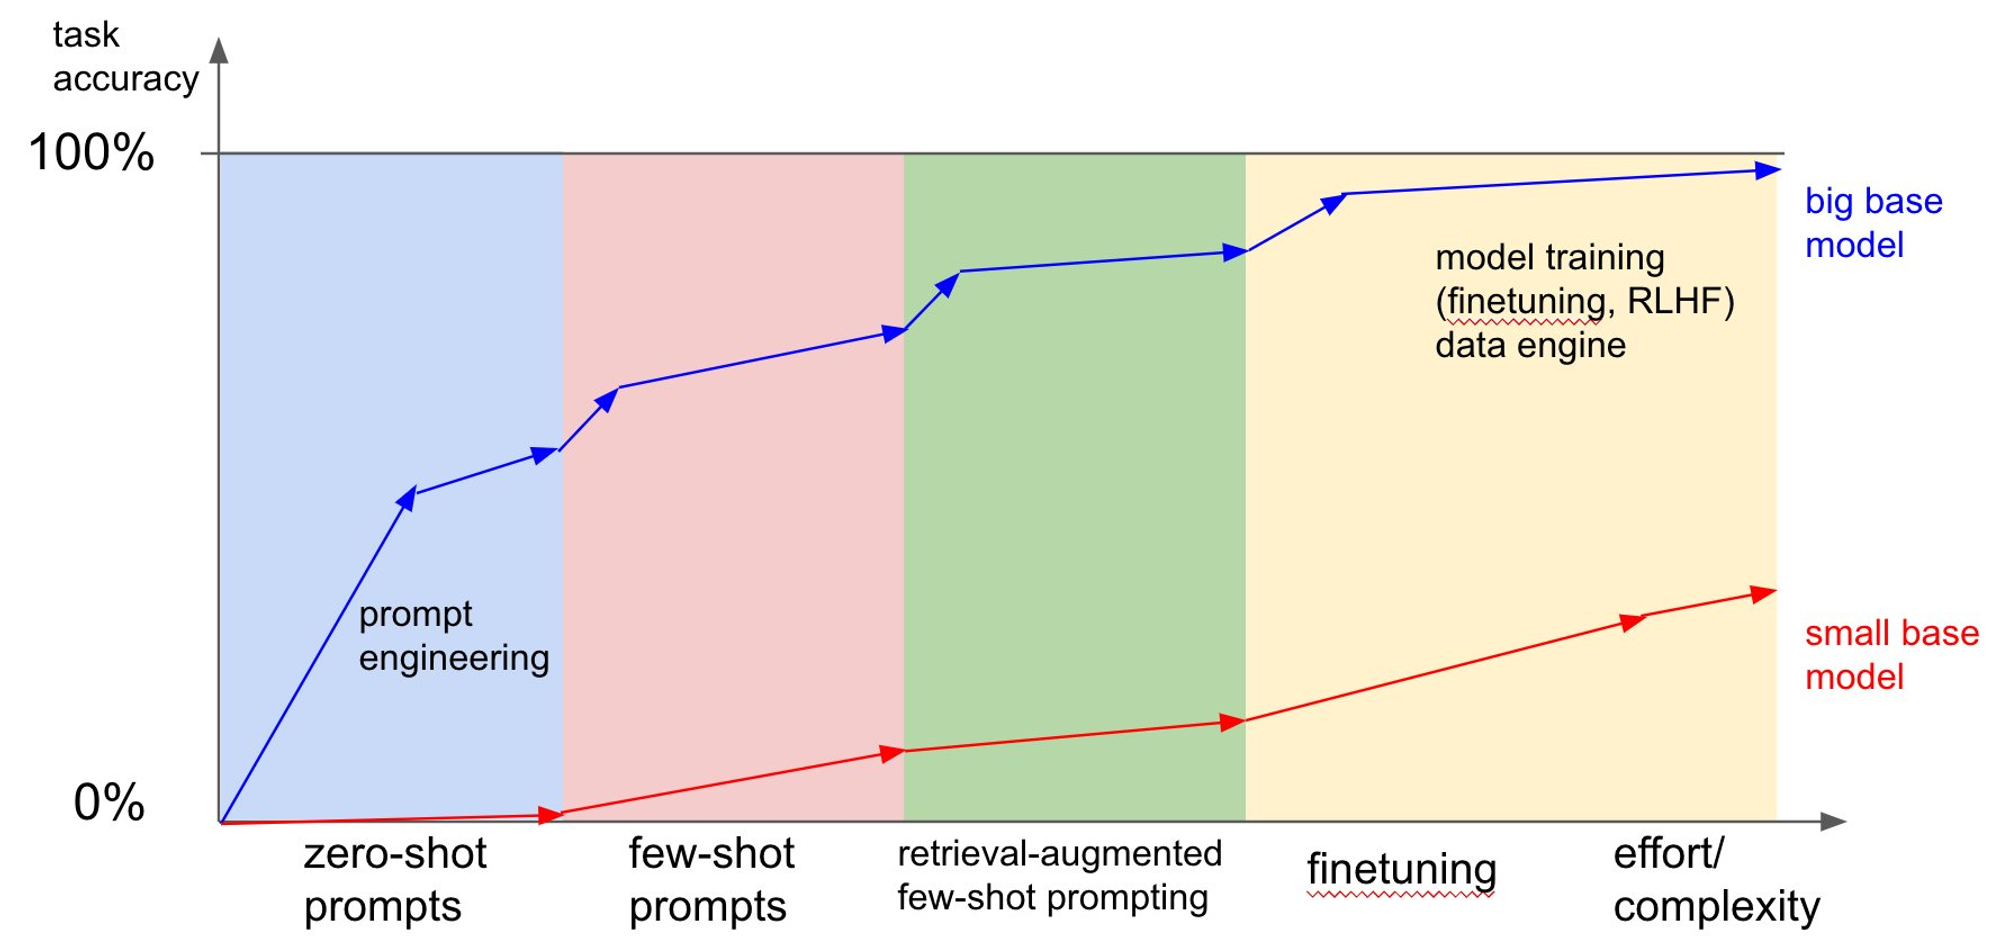

In [5]:
import base64
import io
import os

import numpy as np
from IPython.display import HTML, display
from PIL import Image


def encode_image(image_path):
    """Getting the base64 string"""

    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def plt_img_base64(img_base64):
    """Display the base64 image"""

    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))


# Image for QA
path = "/Users/rlm/Desktop/Multimodal_Eval/qa/llm_strategies.jpeg"
img_base64 = encode_image(path)
plt_img_base64(img_base64)

## QA with GPT-4Vision

We can use GPT-4V to perform QA on images. See here for more detail:
* https://github.com/openai/openai-python/releases/tag/v1.0.0
* https://platform.openai.com/docs/guides/vision

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

In [7]:
chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

msg = chat.invoke(
    [
        HumanMessage(
            content=[
                {
                    "type": "text",
                    "text": "Based on the image, what is the difference in training strategy between a small and a large base model?",
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                },
            ]
        )
    ]
)

The results `msg.content` is shown below:

The image appears to be a graph depicting the task accuracy of two different base model sizes (big and small) as a function of different training strategies and the effort/complexity associated with them. Here's a description of the differences in training strategy between a small and a large base model as suggested by the graph:

1. **Zero-shot prompts**: Both models start with some baseline accuracy with no additional training, which is indicative of zero-shot learning capabilities. However, the big base model shows higher accuracy out of the box compared to the small base model.

2. **Prompt engineering**: As the complexity increases with prompt engineering, the big base model shows a significant improvement in task accuracy, indicating that it can understand and leverage well-engineered prompts more effectively than the small base model.

3. **Few-shot prompts**: With the introduction of few-shot prompts, where the model is given a few examples to learn from, the big base model continues to show higher task accuracy in comparison to the small base model, which also improves but not to the same extent.

4. **Retrieval-augmented few-shot prompting**: At this stage, the models are enhanced with retrieval mechanisms to assist in the few-shot learning process. The big base model maintains a lead in task accuracy, demonstrating that it can better integrate retrieval-augmented strategies.

5. **Finetuning**: As we move towards the right side of the graph, which represents finetuning, the small base model shows a more significant increase in accuracy compared to previous steps, suggesting that finetuning has a substantial impact on smaller models. The big base model, while also benefiting from finetuning, does not show as dramatic an increase, likely because it was already performing at a higher level due to its larger size and capacity.

6. **Model training (finetuning, RLHF) & data engine**: The final section of the graph indicates that with extensive model training techniques like finetuning and Reinforcement Learning from Human Feedback (RLHF), combined with a robust data engine, the big base model can achieve near-perfect task accuracy. The small base model also improves but does not reach the same level, indicating that the larger model's capacity enables it to better utilize advanced training methods and data resources.

In summary, the big base model benefits more from advanced training strategies and demonstrates higher task accuracy with increased effort and complexity, while the small base model requires more significant finetuning to achieve substantial improvements in performance.


## QA with OSS Multi-modal LLMs

We cam also test various open source multi-modal LLMs.

See [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb) for instructions to build llama.cpp for multi-modal LLMs:

Clone [llama.cpp](https://github.com/ggerganov/llama.cpp)

Download the weights:
* [LLaVA-7b](https://huggingface.co/mys/ggml_llava-v1.5-7b/tree/main)
* [LLaVA-13b](https://huggingface.co/mys/ggml_llava-v1.5-13b)
* [Bakllava](https://huggingface.co/mys/ggml_bakllava-1/tree/main)

Build in your `llama.cpp` directory:
```
mkdir build && cd build && cmake ..
cmake --build .
```

Support for multi-modal LLMs will [soon be added to llama.cpp](https://github.com/abetlen/llama-cpp-python/issues/813).

In the meantime, you can test them with the CLI:

In [ ]:
%%bash

# Define the path to the image
IMG_PATH="/Users/rlm/Desktop/Multimodal_Eval/qa/llm_strategies.jpeg"

# Define the model name
#MODEL_NAME="llava-7b"
#MODEL_NAME="bakllava-1"
MODEL_NAME="llava-13b"

# Execute the command and save the output to the defined output file
/Users/rlm/Desktop/Code/llama.cpp/build/bin/llava -m /Users/rlm/Desktop/Code/llama.cpp/models/${MODEL_NAME}/ggml-model-q5_k.gguf --mmproj /Users/rlm/Desktop/Code/llama.cpp/models/${MODEL_NAME}/mmproj-model-f16.gguf --temp 0.1 -p "Based on the image, what is the difference in training strategy between a small and a large base model?" --image "$IMG_PATH"